In [1]:
import numpy as np
import pandas as pd
from itertools import product
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 数据加载

train = pd.read_csv('./train.csv')
train

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


In [2]:
# 转换为pandas中的日期格式
train['Datetime'] = pd.to_datetime(train['Datetime'])
train

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2
...,...,...,...
18283,18283,2014-09-25 19:00:00,868
18284,18284,2014-09-25 20:00:00,732
18285,18285,2014-09-25 21:00:00,702
18286,18286,2014-09-25 22:00:00,580


In [3]:
# 将Datetime作为index
train.index = train['Datetime']
train

,ID,Datetime,Count
Datetime,,,
2012-08-25 00:00:00,0,2012-08-25 00:00:00,8
2012-08-25 01:00:00,1,2012-08-25 01:00:00,2
2012-08-25 02:00:00,2,2012-08-25 02:00:00,6
2012-08-25 03:00:00,3,2012-08-25 03:00:00,2
2012-08-25 04:00:00,4,2012-08-25 04:00:00,2
...,...,...,...
2014-09-25 19:00:00,18283,2014-09-25 19:00:00,868
2014-09-25 20:00:00,18284,2014-09-25 20:00:00,732
2014-09-25 21:00:00,18285,2014-09-25 21:00:00,702


In [4]:
train.drop(['ID','Datetime'], axis = 1, inplace = True)
train

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2
...,...
2014-09-25 19:00:00,868
2014-09-25 20:00:00,732
2014-09-25 21:00:00,702


## 方法1：采用fbprophet模型
## fbprophet暂时没有安装成功

In [5]:
# 按照天D进行采样
daily_train = train.resample('D').sum()
daily_train

,Count
Datetime,
2012-01-09,112
2012-01-10,248
2012-01-11,304
2012-01-12,210
2012-01-13,0
...,...
2014-12-05,6826
2014-12-06,7540
2014-12-07,5858


In [6]:
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train['Count']
daily_train.drop(['Count'], axis = 1, inplace = True)
daily_train

,ds,y
Datetime,,
2012-01-09,2012-01-09,112
2012-01-10,2012-01-10,248
2012-01-11,2012-01-11,304
2012-01-12,2012-01-12,210
2012-01-13,2012-01-13,0
...,...,...
2014-12-05,2014-12-05,6826
2014-12-06,2014-12-06,7540
2014-12-07,2014-12-07,5858


In [7]:
# from fbprophet import Prophet
# # 创建模型
# m = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.1)
# m.fit(daily_train)
# # 预测未来7个月，213天
# future = m.make_future_dataframe(periods=213)
# future


In [8]:
# forecast = m.predict(future)
# forecast

In [9]:
# m.plot(forecast)

## 方法2：采用ARIMA模型

In [10]:
# 按照天D进行采样
daily_train2 = train.resample('D').sum()
daily_train2

,Count
Datetime,
2012-01-09,112
2012-01-10,248
2012-01-11,304
2012-01-12,210
2012-01-13,0
...,...
2014-12-05,6826
2014-12-06,7540
2014-12-07,5858


In [11]:
# 设置参数范围
ps = range(0, 5)
ds = range(0, 2)
qs = range(0, 5)

parameters = product(ps, ds, qs) # 笛卡尔积，所有可能性
parameters_list = list(parameters)
# parameters_list

In [12]:
# 寻找最优ARIMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

for param in parameters_list:
    try:
        #model = ARIMA(daily_train2.Count,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(daily_train2.Count,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
        
    except ValueError:
        print('参数错误:', param)
        continue
        
    aic = model.aic
    # 打擂法，找最小值或最大值
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
# print(results)
print('最优模型: ', best_model.summary()) # Model:               SARIMAX(0, 1, 4)

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                 1066
Model:               SARIMAX(0, 1, 4)   Log Likelihood               -9421.267
Date:                Mon, 22 Mar 2021   AIC                          18852.534
Time:                        23:14:11   BIC                          18877.364
Sample:                    01-09-2012   HQIC                         18861.945
                         - 12-09-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4020      0.020    -20.597      0.000      -0.440      -0.364
ma.L2         -0.1614      0.021     -7.534      0.000      -0.203      -0.119
ma.L3         -0.1715      0.021     -8.067  

In [13]:
# 设置future_day，需要预测的时间date_list

print(daily_train2)
future_day = 213
last_day = pd.to_datetime(daily_train2.index[len(daily_train2)-1])
print(last_day) # 2014-12-09 00:00:00
print('-'*50)

date_list = []
for i in range(future_day):
    i=i+1
    temp_day = last_day + timedelta(days=i)
#     print(temp_day)
    date_list.append(temp_day)
    
print('date_list=', date_list[:5])
print('date_list=', date_list[-5:])

            Count
Datetime         
2012-01-09    112
2012-01-10    248
2012-01-11    304
2012-01-12    210
2012-01-13      0
...           ...
2014-12-05   6826
2014-12-06   7540
2014-12-07   5858
2014-12-08  14762
2014-12-09   9010

[1066 rows x 1 columns]
2014-12-09 00:00:00
--------------------------------------------------
date_list= [Timestamp('2014-12-10 00:00:00', freq='D'), Timestamp('2014-12-11 00:00:00', freq='D'), Timestamp('2014-12-12 00:00:00', freq='D'), Timestamp('2014-12-13 00:00:00', freq='D'), Timestamp('2014-12-14 00:00:00', freq='D')]
date_list= [Timestamp('2015-07-06 00:00:00', freq='D'), Timestamp('2015-07-07 00:00:00', freq='D'), Timestamp('2015-07-08 00:00:00', freq='D'), Timestamp('2015-07-09 00:00:00', freq='D'), Timestamp('2015-07-10 00:00:00', freq='D')]


In [14]:
# 添加未来要预测的7个月，213天
future = pd.DataFrame(index=date_list, columns= daily_train2.columns)
# concat 默认行拼接
daily_train2 = pd.concat([daily_train2, future])
print(daily_train2)


           Count
2012-01-09   112
2012-01-10   248
2012-01-11   304
2012-01-12   210
2012-01-13     0
...          ...
2015-07-06   NaN
2015-07-07   NaN
2015-07-08   NaN
2015-07-09   NaN
2015-07-10   NaN

[1279 rows x 1 columns]


In [15]:
# get_prediction得到的是区间，使用predicted_mean
daily_train2['forecast'] = best_model.get_prediction(start=0, end=len(daily_train2)).predicted_mean
print(daily_train2)

           Count     forecast
2012-01-09   112     0.000000
2012-01-10   248   112.000000
2012-01-11   304   206.211507
2012-01-12   210   259.136528
2012-01-13     0   195.030022
...          ...          ...
2015-07-06   NaN  3761.533311
2015-07-07   NaN  3761.533311
2015-07-08   NaN  3761.533311
2015-07-09   NaN  3761.533311
2015-07-10   NaN  3761.533311

[1279 rows x 2 columns]


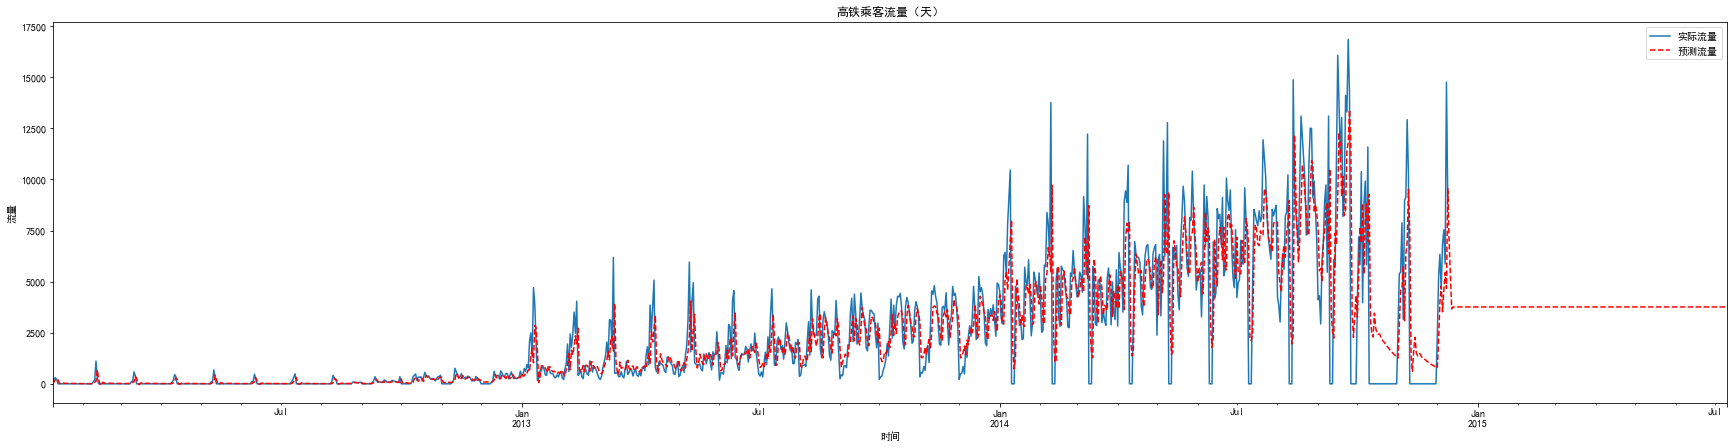

In [16]:
# 高铁乘客流量预测结果显示
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.figure(figsize=(30,7))
daily_train2.Count.plot(label='实际流量')
daily_train2.forecast.plot(color='r', ls='--', label='预测流量')
plt.legend()
plt.title('高铁乘客流量（天）')
plt.xlabel('时间')
plt.ylabel('流量')
plt.show()

## 问题：
## 为什么SARIMAX在未来7个月内的预测流量都是一个值？
## 我哪里写的不对啊，请老师指教~